# Data preprocessing for Fusion and Model

Importing Libraries

In [76]:
# Essentials
import pandas as pd
import numpy as np

# Processing
from sklearn.preprocessing import StandardScaler

# Model

# Visualization

# Warnings
import warnings
warnings.filterwarnings('ignore')

Loading Datasets

In [77]:
# Clinical Datasets
African = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/African_pro.csv")
Bangladesh = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/Bangladesh_pro.csv")
Iraq = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/clinical/Iraq_pro.csv")

# Genetic Datasets
inter_genetic = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/genetic/inter_genetic_dataset.csv")
normal_genetic = pd.read_csv("/Users/mohammedbasem/Desktop/T2D-Prediction-System--Data-Fusion-for-Enhanced-Decision-Making/processed_datasets/genetic/normal_genetic_dataset.csv")

Checking Target Columns

In [78]:
print(African.columns, "\n")
print(Bangladesh.columns, "\n")
print(Iraq.columns, "\n")
print(inter_genetic.columns, "\n")
print(normal_genetic.columns)

Index(['Patient number', 'Cholesterol', 'Glucose', 'HDL Chol',
       'Chol/HDL ratio', 'Age', 'Gender', 'Height', 'Weight', 'BMI',
       'Systolic BP', 'Diastolic BP', 'waist', 'hip', 'Waist/hip ratio',
       'Diabetes', 'BMI Category'],
      dtype='object') 

Index(['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose', 'height',
       'weight', 'bmi', 'family_diabetes', 'hypertensive',
       'family_hypertension', 'cardiovascular_disease', 'stroke',
       'gender_Encoded', 'diabetic_Encoded'],
      dtype='object') 

Index(['Age', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI',
       'Gender_Encoded', 'Class_Encoded'],
      dtype='object') 

Index(['STUDY', 'DISEASE_DESCRIPTION', 'REGION', 'CHR_ID', 'CHR_POS',
       'MAPPED_GENE', 'UPSTREAM_GENE_ID', 'DOWNSTREAM_GENE_ID',
       'UPSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_DISTANCE', 'SNPS', 'MERGED',
       'GENOMIC_CONTEXT', 'INTERGENIC', 'RISK_ALLELE_FREQUENCY', 'PVALUE',
       'PVALUE_MLOG', 'EF

Uniting Target Columns' name

In [79]:
African.rename(columns={
    'Diabetes': 'T2D',
}, inplace=True)
 
Bangladesh.rename(columns={
    'diabetic_Encoded': 'T2D',
}, inplace=True)
 
Iraq.rename(columns={
    'Class_Encoded': 'T2D',
}, inplace=True)
 
# Add a new column 'T2D' with all values set to 1
#inter_genetic['T2D'] = 1
 
# Add a new column 'T2D' with all values set to 1
#normal_genetic['T2D'] = 1

Checking Data Types 

In [80]:
print(African.dtypes, '\n')
print(Bangladesh.dtypes, '\n')
print(Iraq.dtypes, '\n')
print(inter_genetic.dtypes, '\n')
print(normal_genetic.dtypes, '\n')

Patient number       int64
Cholesterol          int64
Glucose              int64
HDL Chol             int64
Chol/HDL ratio     float64
Age                  int64
Gender               int64
Height               int64
Weight               int64
BMI                float64
Systolic BP          int64
Diastolic BP         int64
waist                int64
hip                  int64
Waist/hip ratio    float64
T2D                  int64
BMI Category         int64
dtype: object 

age                         int64
pulse_rate                  int64
systolic_bp                 int64
diastolic_bp                int64
glucose                   float64
height                    float64
weight                    float64
bmi                       float64
family_diabetes             int64
hypertensive                int64
family_hypertension         int64
cardiovascular_disease      int64
stroke                      int64
gender_Encoded              int64
T2D                         int64
dtype: object 


Checking number of columns and rows

In [81]:
print(African.shape, '\n')
print(Bangladesh.shape, '\n')
print(Iraq.shape, '\n')
print(inter_genetic.shape, '\n')
print(normal_genetic.shape, '\n')

(390, 17) 

(5437, 15) 

(786, 12) 

(1110, 28) 

(2141, 25) 



# Generative Adversarial Networks (GANs)

Define GAN Architecture

In [82]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [83]:
# Define Generator model
def build_generator(input_dim, output_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(output_dim, activation='tanh')
    ])
    return model

# Define Discriminator model
def build_discriminator(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')  # Output probability (Real vs Fake)
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Normalizing for `inter_genetic`

In [84]:
# Selecting only numerical columns
numerical_cols = inter_genetic.select_dtypes(include=['number']).columns

# Normalizing only numerical columns
scaler = MinMaxScaler()
inter_genetic_scaled = inter_genetic.copy()  # Copying original dataframe
inter_genetic_scaled[numerical_cols] = scaler.fit_transform(inter_genetic[numerical_cols])


Build and Compile the GAN for `inter_genetic`

In [85]:
input_dim = inter_genetic_scaled.shape[1]  # Number of features
generator = build_generator(100, input_dim)  # Generator takes 100 noise dimensions
discriminator = build_discriminator(input_dim)

# Create GAN model (combining Generator & Discriminator)
discriminator.trainable = False  # Freeze discriminator during GAN training

gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [86]:
inter_genetic_scaled = inter_genetic_scaled.apply(pd.to_numeric, errors='coerce').astype(np.float32)


In [87]:
inter_genetic_scaled = inter_genetic_scaled.astype(np.float32)


In [88]:
print(inter_genetic_scaled.dtypes)


STUDY                           float32
DISEASE_DESCRIPTION             float32
REGION                          float32
CHR_ID                          float32
CHR_POS                         float32
MAPPED_GENE                     float32
UPSTREAM_GENE_ID                float32
DOWNSTREAM_GENE_ID              float32
UPSTREAM_GENE_DISTANCE          float32
DOWNSTREAM_GENE_DISTANCE        float32
SNPS                            float32
MERGED                          float32
GENOMIC_CONTEXT                 float32
INTERGENIC                      float32
RISK_ALLELE_FREQUENCY           float32
PVALUE                          float32
PVALUE_MLOG                     float32
EFFECT_SIZE                     float32
CASE_PERCENTAGE                 float32
CI_LOWER_BOUND                  float32
CI_UPPER_BOUND                  float32
CI_RANGE                        float32
SNPS_PASSING_QC                 float32
PLATFORM_AFFYMETRIX             float32
PLATFORM_AFFYMETRIX_ILLUMINA    float32


Train the GAN for `inter_genetic`

In [89]:
#edited

def train_gan(epochs, batch_size):
    real_labels = np.ones((batch_size, 1))  # Label 1 for real data (Yes)
    fake_labels = np.zeros((batch_size, 1))  # Label 0 for fake data (No)
 
    for epoch in range(epochs):
        # Select a random batch of real samples
        idx = np.random.randint(0, inter_genetic_scaled.shape[0], batch_size)
        real_samples = inter_genetic_scaled.iloc[idx]  # ✅ Fixed: Use iloc
 
        # Generate fake samples
        noise = np.random.normal(0, 1, (batch_size, 100))  # Noise input
        fake_samples = generator.predict(noise)
 
        # Train the Discriminator
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
 
        # Extract loss values properly
        d_loss_real_value = d_loss_real[0] if isinstance(d_loss_real, (list, tuple, np.ndarray)) else d_loss_real
        d_loss_fake_value = d_loss_fake[0] if isinstance(d_loss_fake, (list, tuple, np.ndarray)) else d_loss_fake
        d_loss = 0.5 * (d_loss_real_value + d_loss_fake_value)  # Compute average loss
 
        # Train the Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real_labels)  # Directly assign g_loss
 
        # Print loss every epoch
        print(f"Epoch {epoch}: D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")
 
# Train the GAN
train_gan(epochs=25, batch_size=16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch 0: D Loss: nan, G Loss: 0.5730
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1: D Loss: nan, G Loss: 0.5768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 2: D Loss: nan, G Loss: 0.5735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 3: D Loss: nan, G Loss: 0.5700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 4: D Loss: nan, G Loss: 0.5682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 5: D Loss: nan, G Loss: 0.5619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 6: D Loss: nan, G Loss: 0.5586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 7: D Loss: nan, G Loss: 0.5568
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 8: D Loss: nan, G Loss: 0.5521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 9: D Loss: nan, G Loss: 0.5499
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 10: D Loss: nan, G Loss: 0.5447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 11: D Loss: nan, G Loss: 0.5427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 12: D Loss: nan, G Loss: 0.5396
1/1 ━━━━━━━━━━━━━━━━━━

Generate Synthetic "No" Samples for `inter_genetic`

In [90]:
import numpy as np
import pandas as pd

# Step 1: Ensure Generator Inputs Match Expected Noise Dim
num_samples = 1110
noise_dim = generator.input_shape[1]  # Get correct input size
noise = np.random.normal(0, 1, (num_samples, noise_dim))  # Generate noise

# Step 2: Generate Fake "No" Samples
synthetic_no_samples = generator.predict(noise)

# Step 3: Apply inverse_transform only on numerical columns
synthetic_no_samples_scaled = scaler.inverse_transform(synthetic_no_samples[:, :scaler.scale_.shape[0]])

# Step 4: Convert to DataFrame with Correct Column Names
synthetic_df = pd.DataFrame(synthetic_no_samples_scaled, columns=inter_genetic.columns[:scaler.scale_.shape[0]])

# Step 5: Add Missing Categorical Columns Randomly (Ensure IMPUTED_ENCODED & RISK_ALLELE_ENCODED are added)
for col in inter_genetic.columns[scaler.scale_.shape[0]:-1]:  # Exclude target column
    if col in ["IMPUTED_ENCODED", "RISK_ALLELE_ENCODED"]:  # ✅ Ensure these columns are restored
        synthetic_df[col] = np.random.choice(inter_genetic[col].values, size=len(synthetic_df))
    else:  # ✅ Add all other categorical columns normally
        synthetic_df[col] = np.random.choice(inter_genetic[col].values, size=len(synthetic_df))

# Step 6: Label Synthetic Samples as "No" (0)
synthetic_df['T2D'] = 0

# Step 7: Label Original Samples as "Yes" (1)
inter_genetic['T2D'] = 1

# Step 8: Combine Real and Synthetic Data
balanced_inter_genetic = pd.concat([inter_genetic, synthetic_df], ignore_index=True)

# Step 9: Fill Missing `IMPUTED_ENCODED` & `RISK_ALLELE_ENCODED` Values (If Any)
for col in ["IMPUTED_ENCODED", "RISK_ALLELE_ENCODED"]:
    if balanced_inter_genetic[col].isnull().sum() > 0:
        real_values = balanced_inter_genetic.loc[balanced_inter_genetic['T2D'] == 1, col]
        balanced_inter_genetic.loc[balanced_inter_genetic['T2D'] == 0, col] = np.random.choice(
            real_values, size=(balanced_inter_genetic['T2D'] == 0).sum(), replace=True
        )

# Step 10: Check the distribution of labels
print(balanced_inter_genetic['T2D'].value_counts())

# Step 11: Verify Fixes
print("Null values in IMPUTED_ENCODED:", balanced_inter_genetic['IMPUTED_ENCODED'].isnull().sum())
print("Null values in RISK_ALLELE_ENCODED:", balanced_inter_genetic['RISK_ALLELE_ENCODED'].isnull().sum())
print("Final columns:", balanced_inter_genetic.columns)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
T2D
1    1110
0    1110
Name: count, dtype: int64
Null values in IMPUTED_ENCODED: 0
Null values in RISK_ALLELE_ENCODED: 0
Final columns: Index(['STUDY', 'DISEASE_DESCRIPTION', 'REGION', 'CHR_ID', 'CHR_POS',
       'MAPPED_GENE', 'UPSTREAM_GENE_ID', 'DOWNSTREAM_GENE_ID',
       'UPSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_DISTANCE', 'SNPS', 'MERGED',
       'GENOMIC_CONTEXT', 'INTERGENIC', 'RISK_ALLELE_FREQUENCY', 'PVALUE',
       'PVALUE_MLOG', 'EFFECT_SIZE', 'CASE_PERCENTAGE', 'CI_LOWER_BOUND',
       'CI_UPPER_BOUND', 'CI_RANGE', 'SNPS_PASSING_QC', 'PLATFORM_AFFYMETRIX',
       'PLATFORM_AFFYMETRIX_ILLUMINA', 'PLATFORM_ILLUMINA', 'IMPUTED_ENCODED',
       'RISK_ALLELE_ENCODED', 'T2D'],
      dtype='object')


In [91]:
inter_genetic.head()

,STUDY,DISEASE_DESCRIPTION,REGION,CHR_ID,CHR_POS,MAPPED_GENE,UPSTREAM_GENE_ID,DOWNSTREAM_GENE_ID,UPSTREAM_GENE_DISTANCE,DOWNSTREAM_GENE_DISTANCE,...,CI_LOWER_BOUND,CI_UPPER_BOUND,CI_RANGE,SNPS_PASSING_QC,PLATFORM_AFFYMETRIX,PLATFORM_AFFYMETRIX_ILLUMINA,PLATFORM_ILLUMINA,IMPUTED_ENCODED,RISK_ALLELE_ENCODED,T2D
0,[-1.47616668e-02 5.09463213e-02 2.69961264e-...,[ 1.58013031e-01 9.36319865e-03 -6.81496318e-...,[ 3.05748135e-01 -2.47293934e-01 -1.75472543e-...,8,21853920,[ 1.15677923e-01 4.50637192e-02 -5.24731204e-...,168546,147443,41563,54953,...,0.46,0.56,0.09,6494962,0,1,0,1,0,1
1,[-1.47616668e-02 5.09463213e-02 2.69961264e-...,[ 1.58013031e-01 9.36319865e-03 -6.81496318e-...,[ 3.67390394e-01 -3.92685801e-01 1.06864296e-...,12,5284163,[ 2.10065857e-01 -2.48143420e-01 -4.31279140e-...,256115,185652,39964,147945,...,0.46,0.56,0.09,6494962,0,1,0,1,0,1
2,[ 1.53467417e-01 -1.21334471e-01 7.48024210e-...,[ 1.58013031e-01 9.36319865e-03 -6.81496318e-...,[ 2.82850683e-01 -1.11950912e-01 2.99117025e-...,8,107059816,[ 3.28507662e-01 -2.92603046e-01 -2.57462531e-...,174429,254146,289572,113384,...,1.34,2.08,0.74,6906962,0,1,0,1,1,1
3,[ 4.83314842e-02 1.37150949e-02 -2.07627401e-...,[-1.53973475e-01 1.47206217e-01 -1.56758264e-...,[ 2.93079883e-01 -1.66859761e-01 -1.55704990e-...,7,15013235,[ 3.02324921e-01 -1.51797831e-01 -1.33085012e-...,225816,187546,27161,187082,...,1.04,1.09,0.05,2500000,0,1,0,1,2,1
4,[ 4.83314842e-02 1.37150949e-02 -2.07627401e-...,[-1.53973475e-01 1.47206217e-01 -1.56758264e-...,[ 2.77950853e-01 -2.00821161e-01 -7.99589884e-...,9,22134095,[ 4.64857012e-01 -1.08726546e-01 -2.27923006e-...,240498,176399,5992,312729,...,1.15,1.22,0.07,2500000,0,1,0,1,0,1


Checking null values for `balanced_inter_genetic`

In [92]:
balanced_inter_genetic.isnull().sum()

STUDY                           0
DISEASE_DESCRIPTION             0
REGION                          0
CHR_ID                          0
CHR_POS                         0
MAPPED_GENE                     0
UPSTREAM_GENE_ID                0
DOWNSTREAM_GENE_ID              0
UPSTREAM_GENE_DISTANCE          0
DOWNSTREAM_GENE_DISTANCE        0
SNPS                            0
MERGED                          0
GENOMIC_CONTEXT                 0
INTERGENIC                      0
RISK_ALLELE_FREQUENCY           0
PVALUE                          0
PVALUE_MLOG                     0
EFFECT_SIZE                     0
CASE_PERCENTAGE                 0
CI_LOWER_BOUND                  0
CI_UPPER_BOUND                  0
CI_RANGE                        0
SNPS_PASSING_QC                 0
PLATFORM_AFFYMETRIX             0
PLATFORM_AFFYMETRIX_ILLUMINA    0
PLATFORM_ILLUMINA               0
IMPUTED_ENCODED                 0
RISK_ALLELE_ENCODED             0
T2D                             0
dtype: int64

Nomalizing for `normal_genetic`

In [93]:
# Selecting only numerical columns
numerical_cols = normal_genetic.select_dtypes(include=['number']).columns

# Normalizing only numerical columns
scaler = MinMaxScaler()
normal_genetic_scaled = normal_genetic.copy()  # Copying original dataframe
normal_genetic_scaled[numerical_cols] = scaler.fit_transform(normal_genetic[numerical_cols])


Build and Compile the GAN for `normal_genetic`

In [94]:
# Define input dimension based on normal_genetic dataset
input_dim = normal_genetic_scaled.shape[1]  # Number of features
generator = build_generator(100, input_dim)  # Generator takes 100 noise dimensions
discriminator = build_discriminator(input_dim)

# Create GAN model (combining Generator & Discriminator)
discriminator.trainable = False  # Freeze discriminator during GAN training
gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [95]:
normal_genetic_scaled = normal_genetic_scaled.apply(pd.to_numeric, errors='coerce').astype(np.float32)

In [96]:
normal_genetic_scaled = normal_genetic_scaled.astype(np.float32)

In [97]:
print(normal_genetic_scaled.dtypes)

STUDY                           float32
DISEASE_DESCRIPTION             float32
REGION                          float32
CHR_ID                          float32
CHR_POS                         float32
MAPPED_GENE                     float32
SNP_GENE_IDS                    float32
SNPS                            float32
MERGED                          float32
GENOMIC_CONTEXT                 float32
INTERGENIC                      float32
RISK_ALLELE_FREQUENCY           float32
PVALUE                          float32
PVALUE_MLOG                     float32
EFFECT_SIZE                     float32
CASE_PERCENTAGE                 float32
CI_LOWER_BOUND                  float32
CI_UPPER_BOUND                  float32
CI_RANGE                        float32
SNPS_PASSING_QC                 float32
PLATFORM_AFFYMETRIX             float32
PLATFORM_AFFYMETRIX_ILLUMINA    float32
PLATFORM_ILLUMINA               float32
IMPUTED_ENCODED                 float32
RISK_ALLELE_ENCODED             float32


Train the GAN for `normal_genetic`

In [98]:
def train_gan(epochs, batch_size):
    real_labels = np.ones((batch_size, 1))  # Label 1 for real data (Yes)
    fake_labels = np.zeros((batch_size, 1))  # Label 0 for fake data (No)

    for epoch in range(epochs):
        # Select a random batch of real samples
        idx = np.random.randint(0, normal_genetic_scaled.shape[0], batch_size)
        real_samples = normal_genetic_scaled.iloc[idx].values.astype(np.float32)  # ✅ Convert to float32 NumPy array

        # Generate fake samples
        noise = np.random.normal(0, 1, (batch_size, 100))  # Noise input
        fake_samples = generator.predict(noise)

        # Train the Discriminator
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)

        # Compute average loss
        d_loss_real_value = d_loss_real[0] if isinstance(d_loss_real, (list, tuple, np.ndarray)) else d_loss_real
        d_loss_fake_value = d_loss_fake[0] if isinstance(d_loss_fake, (list, tuple, np.ndarray)) else d_loss_fake
        d_loss = 0.5 * (d_loss_real_value + d_loss_fake_value)

        # Train the Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real_labels)  # Directly assign g_loss

        # Print loss every epoch
        print(f"Epoch {epoch}: D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Train the GAN
train_gan(epochs=25, batch_size=16)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Epoch 0: D Loss: nan, G Loss: 0.7163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1: D Loss: nan, G Loss: 0.7215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 2: D Loss: nan, G Loss: 0.7225
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 3: D Loss: nan, G Loss: 0.7159
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 4: D Loss: nan, G Loss: 0.7190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 5: D Loss: nan, G Loss: 0.7147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 6: D Loss: nan, G Loss: 0.7168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 7: D Loss: nan, G Loss: 0.7138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 8: D Loss: nan, G Loss: 0.7107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 9: D Loss: nan, G Loss: 0.7099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 10: D Loss: nan, G Loss: 0.7039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 11: D Loss: nan, G Loss: 0.7025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 12: D Loss: nan, G Loss: 0.7006
1/1 ━━━━━━━━━━━━━━━━━━

Generate Synthetic "No" Samples for `normal_genetic`

In [99]:
# Step 1: Ensure Generator Inputs Match Expected Noise Dim
num_samples = 1110
noise_dim = generator.input_shape[1]  # Get correct input size
noise = np.random.normal(0, 1, (num_samples, noise_dim))  # Generate noise

# Step 2: Generate Fake "No" Samples
synthetic_no_samples = generator.predict(noise)

# Step 3: Apply inverse_transform only on numerical columns
synthetic_no_samples_scaled = scaler.inverse_transform(synthetic_no_samples[:, :scaler.scale_.shape[0]])

# Step 4: Convert to DataFrame with Correct Column Names
synthetic_df = pd.DataFrame(synthetic_no_samples_scaled, columns=normal_genetic.columns[:scaler.scale_.shape[0]])

# Step 5: Add Missing Categorical Columns Randomly (Ensure IMPUTED_ENCODED & RISK_ALLELE_ENCODED are added)
for col in normal_genetic.columns[scaler.scale_.shape[0]:-1]:  # Exclude target column
    if col in ["IMPUTED_ENCODED", "RISK_ALLELE_ENCODED"]:  # ✅ Ensure these columns are restored
        synthetic_df[col] = np.random.choice(normal_genetic[col].values, size=len(synthetic_df))
    else:  # ✅ Add all other categorical columns normally
        synthetic_df[col] = np.random.choice(normal_genetic[col].values, size=len(synthetic_df))

# Step 6: Label Synthetic Samples as "No" (0)
synthetic_df['T2D'] = 0

# Step 7: Label Original Samples as "Yes" (1)
normal_genetic['T2D'] = 1

# Step 8: Combine Real and Synthetic Data
balanced_normal_genetic = pd.concat([normal_genetic, synthetic_df], ignore_index=True)

# Step 9: Fill Missing `IMPUTED_ENCODED` & `RISK_ALLELE_ENCODED` Values (If Any)
for col in ["IMPUTED_ENCODED", "RISK_ALLELE_ENCODED"]:
    if balanced_normal_genetic[col].isnull().sum() > 0:
        real_values = balanced_normal_genetic.loc[balanced_normal_genetic['T2D'] == 1, col]
        balanced_normal_genetic.loc[balanced_normal_genetic['T2D'] == 0, col] = np.random.choice(
            real_values, size=(balanced_normal_genetic['T2D'] == 0).sum(), replace=True
        )

# Step 10: Check the distribution of labels
print(balanced_normal_genetic['T2D'].value_counts())

# Step 11: Verify Fixes
print("Null values in IMPUTED_ENCODED:", balanced_normal_genetic['IMPUTED_ENCODED'].isnull().sum())
print("Null values in RISK_ALLELE_ENCODED:", balanced_normal_genetic['RISK_ALLELE_ENCODED'].isnull().sum())
print("Final columns:", balanced_normal_genetic.columns)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
T2D
1    2141
0    1110
Name: count, dtype: int64
Null values in IMPUTED_ENCODED: 0
Null values in RISK_ALLELE_ENCODED: 0
Final columns: Index(['STUDY', 'DISEASE_DESCRIPTION', 'REGION', 'CHR_ID', 'CHR_POS',
       'MAPPED_GENE', 'SNP_GENE_IDS', 'SNPS', 'MERGED', 'GENOMIC_CONTEXT',
       'INTERGENIC', 'RISK_ALLELE_FREQUENCY', 'PVALUE', 'PVALUE_MLOG',
       'EFFECT_SIZE', 'CASE_PERCENTAGE', 'CI_LOWER_BOUND', 'CI_UPPER_BOUND',
       'CI_RANGE', 'SNPS_PASSING_QC', 'PLATFORM_AFFYMETRIX',
       'PLATFORM_AFFYMETRIX_ILLUMINA', 'PLATFORM_ILLUMINA', 'IMPUTED_ENCODED',
       'RISK_ALLELE_ENCODED', 'T2D'],
      dtype='object')


In [100]:
balanced_normal_genetic.head()

,STUDY,DISEASE_DESCRIPTION,REGION,CHR_ID,CHR_POS,MAPPED_GENE,SNP_GENE_IDS,SNPS,MERGED,GENOMIC_CONTEXT,...,CI_LOWER_BOUND,CI_UPPER_BOUND,CI_RANGE,SNPS_PASSING_QC,PLATFORM_AFFYMETRIX,PLATFORM_AFFYMETRIX_ILLUMINA,PLATFORM_ILLUMINA,IMPUTED_ENCODED,RISK_ALLELE_ENCODED,T2D
0,[ 1.53467417e-01 -1.21334471e-01 7.48024210e-...,[ 1.58013031e-01 9.36319865e-03 -6.81496318e-...,[ 3.28317851e-01 -2.22687889e-02 5.97555749e-...,1.0,33480230.0,[ 2.26190373e-01 -3.46414000e-01 2.97874417e-...,121903.0,[ 2.22697318e-01 -1.97786130e-02 3.51657197e-...,0.0,[ 2.30852306e-01 -1.53246507e-01 -5.97583354e-...,...,1.37,2.02,0.65,6906962,0,1,0,1,0.0,1
1,[ 1.53467417e-01 -1.21334471e-01 7.48024210e-...,[ 1.58013031e-01 9.36319865e-03 -6.81496318e-...,[ 3.28317851e-01 -2.22687889e-02 5.97555749e-...,1.0,33480000.0,[ 2.26190373e-01 -3.46414000e-01 2.97874417e-...,121903.0,[ 1.39127567e-01 -1.73284680e-01 1.08205833e-...,0.0,[ 2.30852306e-01 -1.53246507e-01 -5.97583354e-...,...,1.68,3.17,1.49,6906962,0,1,0,1,1.0,1
2,[ 4.83314842e-02 1.37150949e-02 -2.07627401e-...,[-1.53973475e-01 1.47206217e-01 -1.56758264e-...,[ 1.94879174e-01 -2.05169976e-01 -5.05079329e-...,7.0,28156794.0,[ 5.20025551e-01 -4.88944441e-01 3.14070396e-...,153814.0,[ 2.49233589e-01 -1.36984721e-01 7.72382393e-...,0.0,[ 2.30852306e-01 -1.53246507e-01 -5.97583354e-...,...,1.08,1.13,0.05,2500000,0,1,0,1,1.0,1
3,[ 4.83314842e-02 1.37150949e-02 -2.07627401e-...,[-1.53973475e-01 1.47206217e-01 -1.56758264e-...,[ 8.26046243e-02 -1.68427393e-01 -1.87586889e-...,7.0,44205764.0,[ 4.80518907e-01 -3.28171670e-01 3.91541887e-...,106636.0,[ 3.10019791e-01 -2.49393567e-01 1.98352784e-...,0.0,[ 2.30852306e-01 -1.53246507e-01 -5.97583354e-...,...,1.04,1.10,0.06,2500000,0,1,0,1,3.0,1
4,[ 4.83314842e-02 1.37150949e-02 -2.07627401e-...,[-1.53973475e-01 1.47206217e-01 -1.56758264e-...,[ 2.34241426e-01 -2.30213180e-01 3.73001061e-...,8.0,41661730.0,[ 5.83934963e-01 -4.24800575e-01 8.80361199e-...,29534.0,[ 3.48467588e-01 -1.68800727e-01 1.54673547e-...,0.0,[ 1.23585604e-01 -3.54309492e-02 -3.14229220e-...,...,1.06,1.12,0.06,2500000,0,1,0,1,2.0,1


Checking null values for `balanced_normal_genetic`

In [101]:
balanced_normal_genetic.isnull().sum()

STUDY                           0
DISEASE_DESCRIPTION             0
REGION                          0
CHR_ID                          0
CHR_POS                         0
MAPPED_GENE                     0
SNP_GENE_IDS                    0
SNPS                            0
MERGED                          0
GENOMIC_CONTEXT                 0
INTERGENIC                      0
RISK_ALLELE_FREQUENCY           0
PVALUE                          0
PVALUE_MLOG                     0
EFFECT_SIZE                     0
CASE_PERCENTAGE                 0
CI_LOWER_BOUND                  0
CI_UPPER_BOUND                  0
CI_RANGE                        0
SNPS_PASSING_QC                 0
PLATFORM_AFFYMETRIX             0
PLATFORM_AFFYMETRIX_ILLUMINA    0
PLATFORM_ILLUMINA               0
IMPUTED_ENCODED                 0
RISK_ALLELE_ENCODED             0
T2D                             0
dtype: int64

Splitting Data

In [102]:
# Splitting datasets into training and testing sets
from sklearn.model_selection import train_test_split

# Splitting African dataset
X_train_african, X_test_african, y_train_african, y_test_african = train_test_split(
    African.drop('T2D', axis=1), African['T2D'], test_size=0.2, random_state=42
)

# Splitting Bangladesh dataset
X_train_bangladesh, X_test_bangladesh, y_train_bangladesh, y_test_bangladesh = train_test_split(
    Bangladesh.drop('T2D', axis=1), Bangladesh['T2D'], test_size=0.2, random_state=42
)

# Splitting Iraq dataset
X_train_iraq, X_test_iraq, y_train_iraq, y_test_iraq = train_test_split(
    Iraq.drop('T2D', axis=1), Iraq['T2D'], test_size=0.2, random_state=42
)

# Splitting Inter Genetic dataset
X_train_inter_genetic, X_test_inter_genetic, y_train_inter_genetic, y_test_inter_genetic = train_test_split(
    balanced_inter_genetic.drop('T2D', axis=1), balanced_inter_genetic['T2D'], test_size=0.2, random_state=42
)

# Splitting Normal Genetic dataset
X_train_normal_genetic, X_test_normal_genetic, y_train_normal_genetic, y_test_normal_genetic = train_test_split(
    balanced_normal_genetic.drop('T2D', axis=1), balanced_normal_genetic['T2D'], test_size=0.2, random_state=42
)

In [103]:
# Importing necessary libraries
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initializing the scaler
scaler = StandardScaler()

# Handling non-numeric data by selecting numeric columns only
def preprocess_and_scale(X_train, X_test):
    # Selecting only numeric columns
    X_train_numeric = X_train.select_dtypes(include=[float, int])
    X_test_numeric = X_test.select_dtypes(include=[float, int])
    
    # Scaling numeric features
    X_train_scaled = scaler.fit_transform(X_train_numeric)
    X_test_scaled = scaler.transform(X_test_numeric)
    
    return X_train_scaled, X_test_scaled

# Preprocessing and scaling for African dataset
X_train_african_scaled, X_test_african_scaled = preprocess_and_scale(
    X_train_african, X_test_african
)

# Preprocessing and scaling for Bangladesh dataset
X_train_bangladesh_scaled, X_test_bangladesh_scaled = preprocess_and_scale(
    X_train_bangladesh, X_test_bangladesh
)

# Preprocessing and scaling for Iraq dataset
X_train_iraq_scaled, X_test_iraq_scaled = preprocess_and_scale(
    X_train_iraq, X_test_iraq
)

# Preprocessing and scaling for Inter Genetic dataset
X_train_inter_genetic_scaled, X_test_inter_genetic_scaled = preprocess_and_scale(
    X_train_inter_genetic, X_test_inter_genetic
)

# Preprocessing and scaling for Normal Genetic dataset
X_train_normal_genetic_scaled, X_test_normal_genetic_scaled = preprocess_and_scale(
    X_train_normal_genetic, X_test_normal_genetic
)

# Model Selection 

Training some machine learning models

In [104]:
# Importing necessary libraries for model selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Defining datasets and corresponding scaled data
datasets = {
    "African": (X_train_african_scaled, X_test_african_scaled, y_train_african, y_test_african),
    "Bangladesh": (X_train_bangladesh_scaled, X_test_bangladesh_scaled, y_train_bangladesh, y_test_bangladesh),
    "Iraq": (X_train_iraq_scaled, X_test_iraq_scaled, y_train_iraq, y_test_iraq),
    "Inter Genetic": (X_train_inter_genetic_scaled, X_test_inter_genetic_scaled, y_train_inter_genetic, y_test_inter_genetic),
    "Normal Genetic": (X_train_normal_genetic_scaled, X_test_normal_genetic_scaled, y_train_normal_genetic, y_test_normal_genetic)
}

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
}

# Looping through each dataset and evaluating models
for dataset_name, (X_train, X_test, y_train, y_test) in datasets.items():
    print(f"\n{dataset_name} Dataset Model Selection Results:")
    results = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)  # Training the model
        y_pred = model.predict(X_test)  # Predicting on the test set
        accuracy = accuracy_score(y_test, y_pred)  # Calculating accuracy
        results[model_name] = accuracy

    # Displaying results for the current dataset
    for model_name, accuracy in results.items():
        print(f"{model_name}: Accuracy = {accuracy:.4f}")


African Dataset Model Selection Results:
Logistic Regression: Accuracy = 0.9103
Random Forest: Accuracy = 0.9103
SVM: Accuracy = 0.8846
KNN: Accuracy = 0.8590
Gradient Boosting: Accuracy = 0.8974
Naive Bayes: Accuracy = 0.8974
Decision Tree: Accuracy = 0.8718

Bangladesh Dataset Model Selection Results:
Logistic Regression: Accuracy = 0.9384
Random Forest: Accuracy = 0.9467
SVM: Accuracy = 0.9403
KNN: Accuracy = 0.9347
Gradient Boosting: Accuracy = 0.9421
Naive Bayes: Accuracy = 0.9053
Decision Tree: Accuracy = 0.9062

Iraq Dataset Model Selection Results:
Logistic Regression: Accuracy = 0.9810
Random Forest: Accuracy = 0.9684
SVM: Accuracy = 0.9684
KNN: Accuracy = 0.9494
Gradient Boosting: Accuracy = 0.9747
Naive Bayes: Accuracy = 0.9620
Decision Tree: Accuracy = 0.9810

Inter Genetic Dataset Model Selection Results:
Logistic Regression: Accuracy = 1.0000
Random Forest: Accuracy = 1.0000
SVM: Accuracy = 0.9977
KNN: Accuracy = 1.0000
Gradient Boosting: Accuracy = 1.0000
Naive Bayes: A

Subplots of Cross Validation for the best model

In [105]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Define the best models for each dataset
best_models_mapping = {
    "African": LogisticRegression(),
    "Bangladesh": RandomForestClassifier(),
    "Iraq": GradientBoostingClassifier(),
    "Inter Genetic": RandomForestClassifier(),
    "Normal Genetic": LogisticRegression(),
}

# Define datasets (replace with actual variable names)
datasets = {
    "African": (X_train_african_scaled, y_train_african),  # Update with correct dataset variable names
    "Bangladesh": (X_train_bangladesh_scaled, y_train_bangladesh),
    "Iraq": (X_train_iraq_scaled, y_train_iraq),
    "Inter Genetic": (X_train_inter_genetic_scaled, y_train_inter_genetic),
    "Normal Genetic": (X_train_normal_genetic_scaled, y_train_normal_genetic),
}

cv_folds = 10  # Number of cross-validation folds
cv_scores = {}

# Perform cross-validation for each dataset's best model
for dataset_name, (X, y) in datasets.items():
    model = best_models_mapping[dataset_name]
    scores = cross_val_score(model, X, y, cv=cv_folds)
    cv_scores[dataset_name] = scores

# Create subplots for each dataset's best model
fig = make_subplots(
    rows=len(datasets), cols=1, shared_xaxes=True,
    subplot_titles=[f"{dataset} ({best_models_mapping[dataset].__class__.__name__}) Cross Validation Scores" 
                    for dataset in datasets.keys()]
)

# Add traces for each dataset's best model
for i, (dataset_name, scores) in enumerate(cv_scores.items(), start=1):
    fig.add_trace(
        go.Scatter(x=list(range(1, len(scores) + 1)), y=scores, name=f"{dataset_name} Scores"),
        row=i, col=1
    )

# Update layout
fig.update_layout(
    height=1500, width=1200,
    title_text="10-Fold Cross Validation for Best Models Across Datasets",
    showlegend=True
)
fig.update_yaxes(title_text="Accuracy Score")
fig.update_xaxes(title_text="Fold #")

# Show the figure
fig.show()

Confusion Matrix, Accuracy, and Classification Report

In [106]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dictionary to store evaluation metrics
evaluation_results = {}

# Compute confusion matrix, accuracy, and classification report for each dataset's best model
for dataset_name, (X, y) in datasets.items():  # Updated to match (X, y) structure
    model = best_models_mapping[dataset_name]
    model.fit(X, y)  # Train the model
    y_pred = model.predict(X)  # Predict on the same dataset (to evaluate performance)

    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Compute accuracy
    accuracy = accuracy_score(y, y_pred)

    # Compute classification report
    class_report = classification_report(y, y_pred, digits=2)

    # Store results
    evaluation_results[dataset_name] = {
        "Confusion Matrix": cm,
        "Accuracy": accuracy,
        "Classification Report": class_report
    }

# Print evaluation results for each dataset
for dataset_name, results in evaluation_results.items():
    print(f"\n{'='*20} {dataset_name} {'='*20}")
    print("Confusion Matrix:")
    print(results["Confusion Matrix"])
    print(f"\nAccuracy: {results['Accuracy']:.2f}")
    print("\nClassification Report:")
    print(results["Classification Report"])
    print("="*60)


==================== African ====================
Confusion Matrix:
[[265   3]
 [ 18  26]]

Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       268
           1       0.90      0.59      0.71        44

    accuracy                           0.93       312
   macro avg       0.92      0.79      0.84       312
weighted avg       0.93      0.93      0.93       312


==================== Bangladesh ====================
Confusion Matrix:
[[4069    0]
 [   1  279]]

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4069
           1       1.00      1.00      1.00       280

    accuracy                           1.00      4349
   macro avg       1.00      1.00      1.00      4349
weighted avg       1.00      1.00      1.00      4349


==================== Iraq ====================
Confusion Matrix:
[[555   0

ROC Curves for Best Models

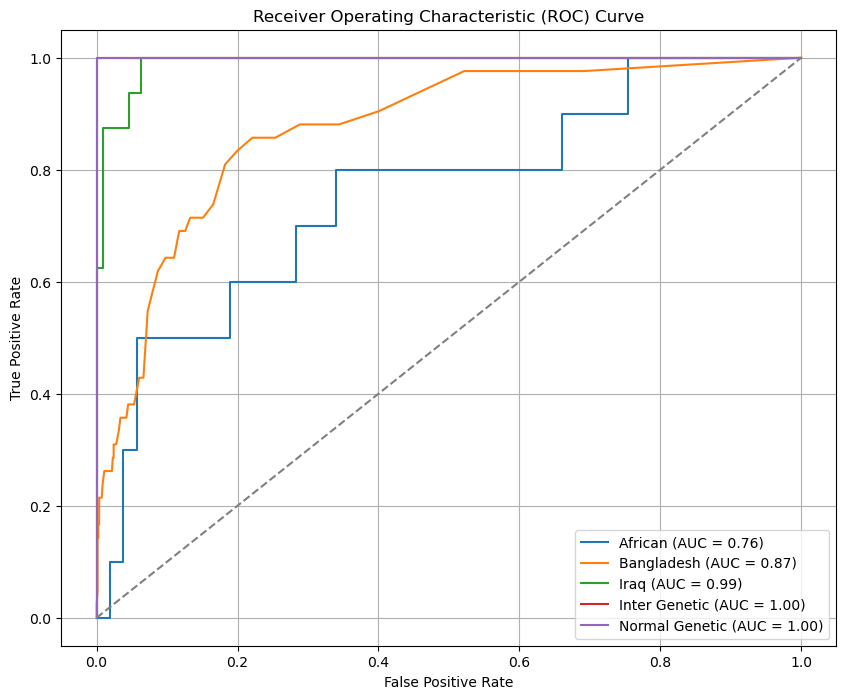

In [107]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Dictionary to store ROC curve data
roc_data = {}

# Compute ROC curve for each dataset's best model
for dataset_name, (X, y) in datasets.items():
    # Split the data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Get the best model for this dataset
    model = best_models_mapping[dataset_name]
    model.fit(X_train, y_train)  # Train the model
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probability estimates for class 1

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Store results
    roc_data[dataset_name] = (fpr, tpr, roc_auc)

# Plot ROC curves for all datasets
plt.figure(figsize=(10, 8))
for dataset_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{dataset_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Feature Importance

In [108]:
from sklearn.ensemble import RandomForestClassifier

feature_importance_results = {}  # Initialize dictionary

# Train a model and extract feature importance for each dataset
for dataset_name, (X, y) in datasets.items():
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    feature_importance_results[dataset_name] = model.feature_importances_


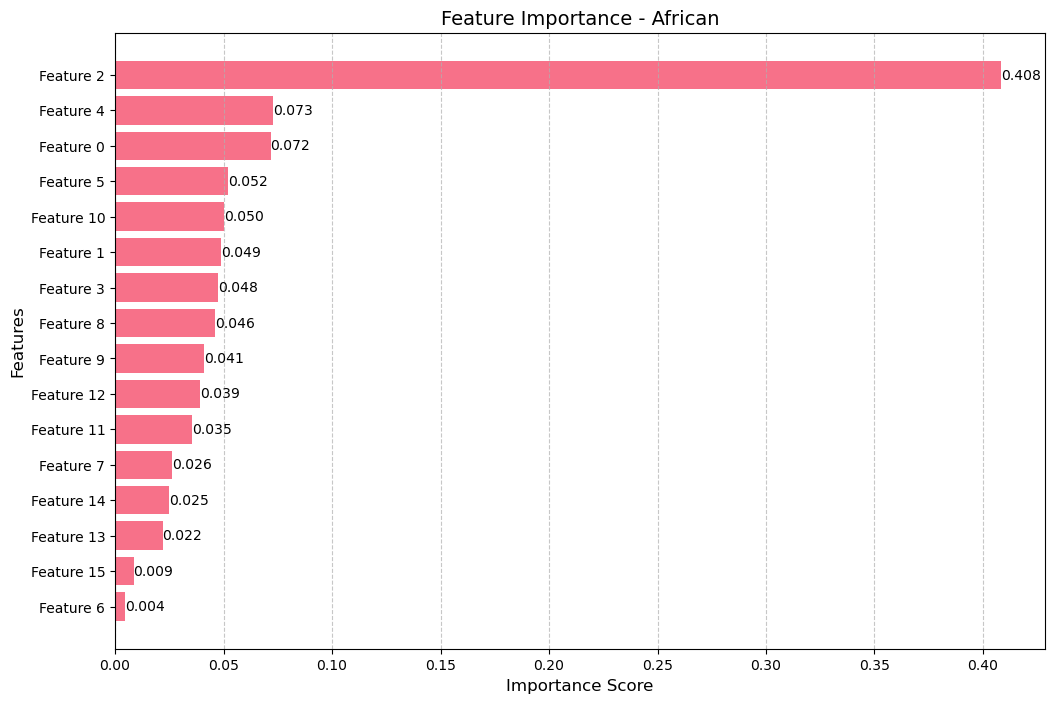

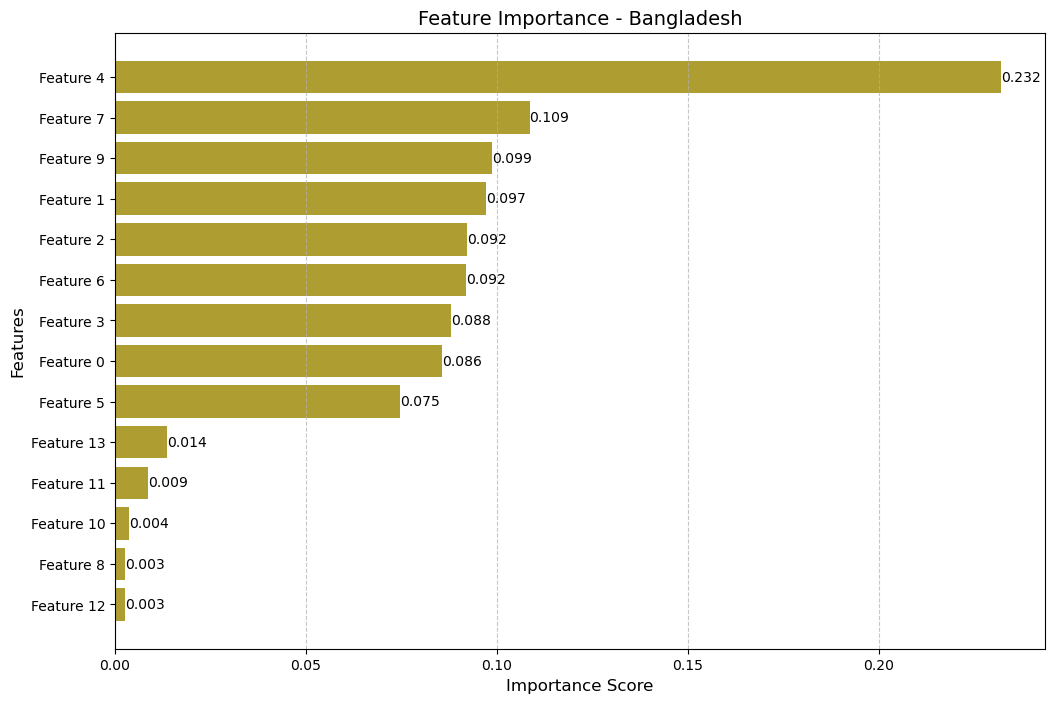

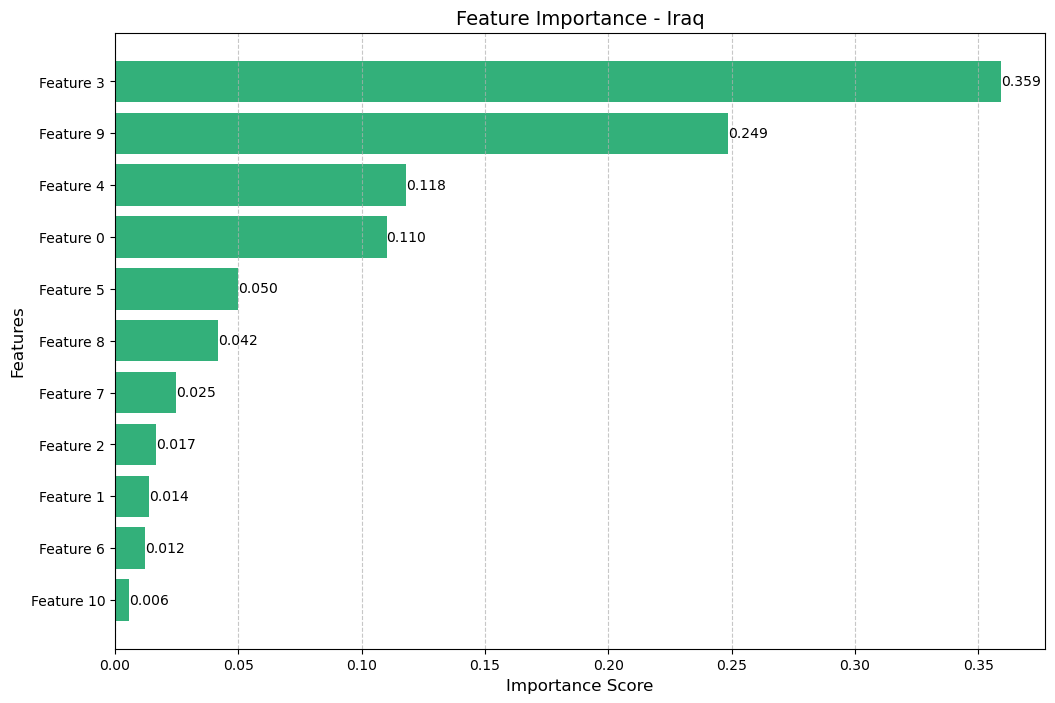

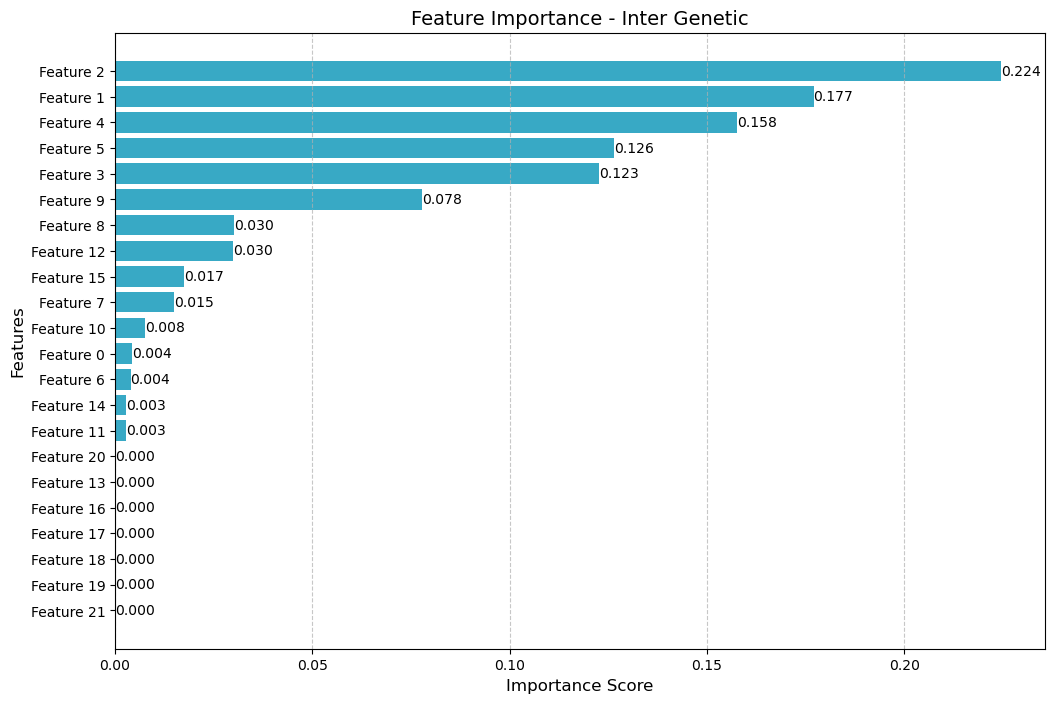

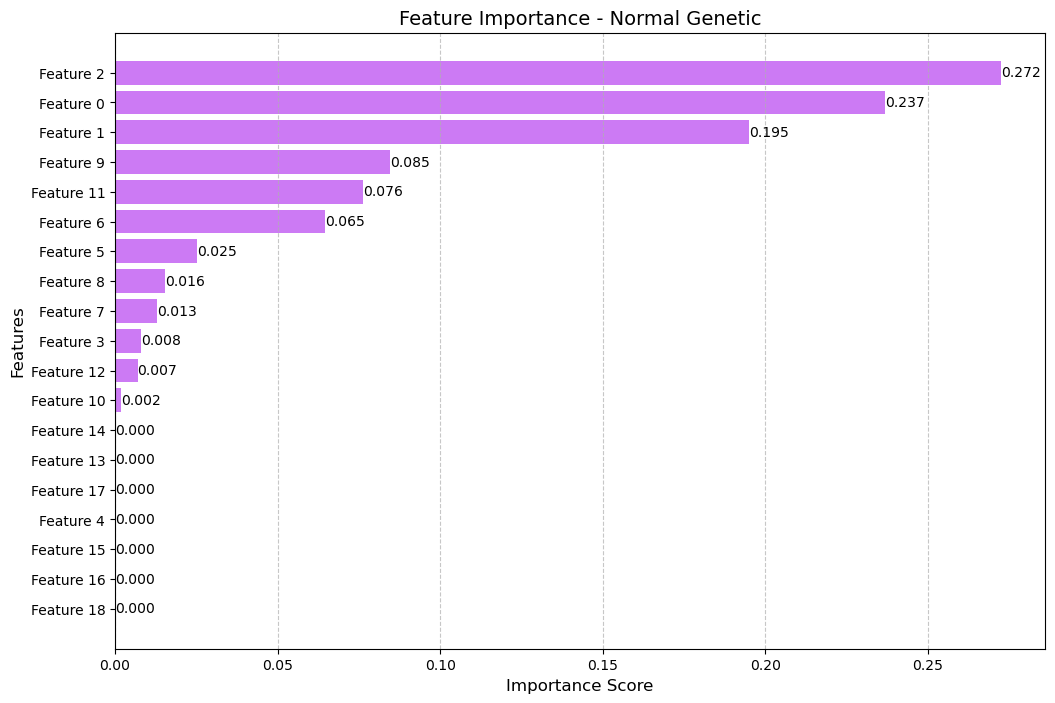

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# Define a color palette for different datasets
color_palette = sns.color_palette("husl", len(datasets))  # Assign unique colors

# Loop through all datasets and generate feature importance plots
for i, (dataset_name, (X, y)) in enumerate(datasets.items()):
    # Ensure feature importance is available
    if dataset_name not in feature_importance_results:
        print(f"⚠ Warning: No feature importance data for {dataset_name}. Skipping...")
        continue

    # Split data into training and testing (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    feature_importances = feature_importance_results[dataset_name]

    # Get correct feature names
    feature_names = X_train.columns if hasattr(X_train, "columns") else [f"Feature {i}" for i in range(len(feature_importances))]

    # Sort feature importances in descending order
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_importances = feature_importances[sorted_indices]

    # Create horizontal bar plot with unique color for each dataset
    plt.figure(figsize=(12, 8))
    bars = plt.barh(sorted_features, sorted_importances, color=color_palette[i])

    # Add labels on bars
    for bar, value in zip(bars, sorted_importances):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{value:.3f}", va='center')

    # Enhance appearance
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title(f"Feature Importance - {dataset_name}", fontsize=14)
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Show plot
    plt.show()

# Data Fusion

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Epoch 1/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4062 - loss: 3.2908Epoch 1: Accuracy = 0.4792, Val Accuracy = 0.4924, Loss = 3.2372, Val Loss = 2.8366, Time = 2.85s
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4642 - loss: 3.2402 - val_accuracy: 0.4924 - val_loss: 2.8366
Epoch 2/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4531 - loss: 3.0428Epoch 2: Accuracy = 0.4962, Val Accuracy = 0.5000, Loss = 3.0970, Val Loss = 2.8303, Time = 0.06s
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4731 - loss: 3.1270 - val_accuracy: 0.5000 - val_loss: 2.8303
Epoch 3/100
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4844 - loss: 3.3158Epoch 3: Accuracy = 0.4867, Val Accuracy = 0.4848, Loss = 3.1491, Val Loss = 2.8238, Time = 0.06s
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4939 - loss: 3.1610 - val_accuracy: 0.4848 - val_loss: 2.8238
Epoch 4

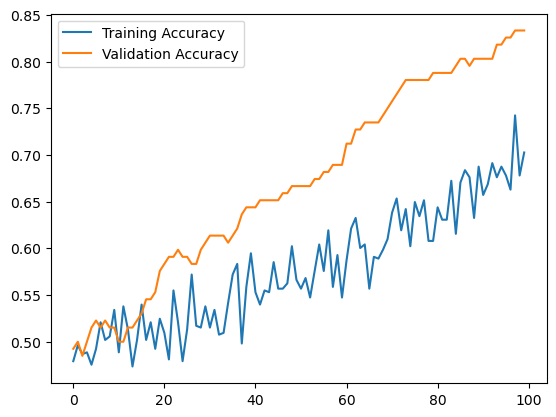

In [110]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


# Drop non-numeric columns
African = African.select_dtypes(include=[np.number])
Bangladesh = Bangladesh.select_dtypes(include=[np.number])
Iraq = Iraq.select_dtypes(include=[np.number])
inter_genetic = inter_genetic.select_dtypes(include=[np.number])
normal_genetic = normal_genetic.select_dtypes(include=[np.number])

# Detect the target column dynamically
target_col = [col for col in African.columns if 't2d' in col.lower()]
if target_col:
    target_col = target_col[0]
else:
    raise ValueError("Target column 'T2D' not found in dataset!")

# Extract features and labels
X_African, y = African.drop(columns=[target_col]), African[target_col]
X_Bangladesh = Bangladesh.drop(columns=[target_col])
X_Iraq = Iraq.drop(columns=[target_col])
X_inter_genetic = inter_genetic.drop(columns=[target_col])
X_normal_genetic = normal_genetic.drop(columns=[target_col])

# Standardize features
scaler = StandardScaler()
X_African_scaled = scaler.fit_transform(X_African)
X_Bangladesh_scaled = scaler.fit_transform(X_Bangladesh)
X_Iraq_scaled = scaler.fit_transform(X_Iraq)
X_inter_genetic_scaled = scaler.fit_transform(X_inter_genetic)
X_normal_genetic_scaled = scaler.fit_transform(X_normal_genetic)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_African_scaled, y = smote.fit_resample(X_African_scaled, y)

# Ensure all datasets have the same number of samples
def upsample_to_target(X, target_size):
    return resample(X, replace=True, n_samples=target_size, random_state=42)

target_size = len(y)  # Use the size of y_train as the reference
X_Bangladesh_scaled = upsample_to_target(X_Bangladesh_scaled, target_size)
X_Iraq_scaled = upsample_to_target(X_Iraq_scaled, target_size)
X_inter_genetic_scaled = upsample_to_target(X_inter_genetic_scaled, target_size)
X_normal_genetic_scaled = upsample_to_target(X_normal_genetic_scaled, target_size)

# Split data into train/test sets
X_train_African, X_test_African, y_train, y_test = train_test_split(X_African_scaled, y, test_size=0.2, random_state=42)
X_train_Bangladesh, X_test_Bangladesh = train_test_split(X_Bangladesh_scaled, test_size=0.2, random_state=42)
X_train_Iraq, X_test_Iraq = train_test_split(X_Iraq_scaled, test_size=0.2, random_state=42)
X_train_inter_genetic, X_test_inter_genetic = train_test_split(X_inter_genetic_scaled, test_size=0.2, random_state=42)
X_train_normal_genetic, X_test_normal_genetic = train_test_split(X_normal_genetic_scaled, test_size=0.2, random_state=42)

# Get feature dimensions
African_dim = X_train_African.shape[1]
Bangladesh_dim = X_train_Bangladesh.shape[1]
Iraq_dim = X_train_Iraq.shape[1]
inter_genetic_dim = X_train_inter_genetic.shape[1]
normal_genetic_dim = X_train_normal_genetic.shape[1]

# Define Neural Networks with Stronger Regularization
def build_branch(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    x = BatchNormalization()(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
    return input_layer, x

# Build Branches
African_input, x1 = build_branch(African_dim)
Bangladesh_input, x2 = build_branch(Bangladesh_dim)
Iraq_input, x3 = build_branch(Iraq_dim)
inter_genetic_input, x4 = build_branch(inter_genetic_dim)
normal_genetic_input, x5 = build_branch(normal_genetic_dim)

# Fusion Layer
merged = Concatenate()([x1, x2, x3, x4, x5])
x = Dense(64, activation='relu')(merged)
x = Dropout(0.6)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.6)(x)
output = Dense(1, activation='sigmoid')(x)

# Build & Compile Model
model = Model(inputs=[African_input, Bangladesh_input, Iraq_input, inter_genetic_input, normal_genetic_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

# Save model visualization
plot_model(model, to_file="model_structure.png", show_shapes=True, show_layer_names=True)

# Custom Training Logger
class CustomTrainingLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"Epoch {epoch+1}: Accuracy = {logs['accuracy']:.4f}, "
              f"Val Accuracy = {logs['val_accuracy']:.4f}, "
              f"Loss = {logs['loss']:.4f}, Val Loss = {logs['val_loss']:.4f}, "
              f"Time = {epoch_time:.2f}s")

callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), CustomTrainingLogger()]

# Train Model
history = model.fit(
    [X_train_African, X_train_Bangladesh, X_train_Iraq, X_train_inter_genetic, X_train_normal_genetic], y_train,
    validation_data=([X_test_African, X_test_Bangladesh, X_test_Iraq, X_test_inter_genetic, X_test_normal_genetic], y_test),
    epochs=100, batch_size=64, callbacks=callbacks)

# Plot Training Curves
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()


In [111]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dictionary to store evaluation metrics
evaluation_results = {}

# Prepare test datasets for evaluation
test_data = {
    "African": X_test_African,
    "Bangladesh": X_test_Bangladesh,
    "Iraq": X_test_Iraq,
    "Inter_Genetic": X_test_inter_genetic,
    "Normal_Genetic": X_test_normal_genetic
}

# Predict on test datasets
y_pred = model.predict([X_test_African, X_test_Bangladesh, X_test_Iraq, X_test_inter_genetic, X_test_normal_genetic])
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix, accuracy, and classification report for the "African" dataset
for dataset_name, X_test in test_data.items():
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute classification report
    class_report = classification_report(y_test, y_pred, digits=2)

    # Store results
    evaluation_results[dataset_name] = {
        "Confusion Matrix": cm,
        "Accuracy": accuracy,
        "Classification Report": class_report
    }

# Print evaluation results for each dataset
for dataset_name, results in evaluation_results.items():
    print(f"\n{'='*20} {dataset_name} {'='*20}")
    print("Confusion Matrix:")
    print(results["Confusion Matrix"])
    print(f"\nAccuracy: {results['Accuracy']:.2f}")
    print("\nClassification Report:")
    print(results["Classification Report"])
    print("="*60)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

==================== African ====================
Confusion Matrix:
[[58 16]
 [ 6 52]]

Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        74
           1       0.76      0.90      0.83        58

    accuracy                           0.83       132
   macro avg       0.84      0.84      0.83       132
weighted avg       0.84      0.83      0.83       132


==================== Bangladesh ====================
Confusion Matrix:
[[58 16]
 [ 6 52]]

Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        74
           1       0.76      0.90      0.83        58

    accuracy                           0.83       132
   macro avg       0.84      0.84      0.83       132
weighted avg       0.84      0.83      0.83       132


==================== Iraq ====================
C

In [112]:
'''import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Find the maximum sample size across all datasets
max_samples = max(len(African), len(Bangladesh), len(Iraq), len(inter_genetic), len(normal_genetic))

# Function to upsample datasets to match the largest dataset
def upsample_data(df, target_size):
    return resample(df, replace=True, n_samples=target_size, random_state=42)

# Upsample all datasets to the same number of rows
African = upsample_data(African, max_samples)
Bangladesh = upsample_data(Bangladesh, max_samples)
Iraq = upsample_data(Iraq, max_samples)
inter_genetic = upsample_data(inter_genetic, max_samples)
normal_genetic = upsample_data(normal_genetic, max_samples)

# Drop non-numeric columns
African = African.select_dtypes(include=[np.number])
Bangladesh = Bangladesh.select_dtypes(include=[np.number])
Iraq = Iraq.select_dtypes(include=[np.number])
inter_genetic = inter_genetic.select_dtypes(include=[np.number])
normal_genetic = normal_genetic.select_dtypes(include=[np.number])

# Detect the target column dynamically
target_col = [col for col in African.columns if 't2d' in col.lower()]
if target_col:
    target_col = target_col[0]  # Get correct column name
else:
    raise ValueError("Target column 'T2D' not found in dataset!")

# Extract features and labels
X_African, y = African.drop(columns=[target_col]), African[target_col]
X_Bangladesh = Bangladesh.drop(columns=[target_col])
X_Iraq = Iraq.drop(columns=[target_col])
X_inter_genetic = inter_genetic.drop(columns=[target_col])
X_normal_genetic = normal_genetic.drop(columns=[target_col])

# Standardize features
scaler = StandardScaler()
X_African_scaled = scaler.fit_transform(X_African)
X_Bangladesh_scaled = scaler.fit_transform(X_Bangladesh)
X_Iraq_scaled = scaler.fit_transform(X_Iraq)
X_inter_genetic_scaled = scaler.fit_transform(X_inter_genetic)
X_normal_genetic_scaled = scaler.fit_transform(X_normal_genetic)

# Split data into train/test sets
X_train_African, X_test_African, y_train, y_test = train_test_split(X_African_scaled, y, test_size=0.2, random_state=42)
X_train_Bangladesh, X_test_Bangladesh = train_test_split(X_Bangladesh_scaled, test_size=0.2, random_state=42)
X_train_Iraq, X_test_Iraq = train_test_split(X_Iraq_scaled, test_size=0.2, random_state=42)
X_train_inter_genetic, X_test_inter_genetic = train_test_split(X_inter_genetic_scaled, test_size=0.2, random_state=42)
X_train_normal_genetic, X_test_normal_genetic = train_test_split(X_normal_genetic_scaled, test_size=0.2, random_state=42)

# Get feature dimensions
African_dim = X_train_African.shape[1]
Bangladesh_dim = X_train_Bangladesh.shape[1]
Iraq_dim = X_train_Iraq.shape[1]
inter_genetic_dim = X_train_inter_genetic.shape[1]
normal_genetic_dim = X_train_normal_genetic.shape[1]

# Define Neural Networks with L2 Regularization
African_input = Input(shape=(African_dim,))
x1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(African_input)
x1 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x1)

Bangladesh_input = Input(shape=(Bangladesh_dim,))
x2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(Bangladesh_input)
x2 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x2)

Iraq_input = Input(shape=(Iraq_dim,))
x3 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(Iraq_input)
x3 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x3)

inter_genetic_input = Input(shape=(inter_genetic_dim,))
x4 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inter_genetic_input)
x4 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x4)

normal_genetic_input = Input(shape=(normal_genetic_dim,))
x5 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(normal_genetic_input)
x5 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x5)

# Fusion Layer
merged = Concatenate()([x1, x2, x3, x4, x5])
x = Dense(128, activation='relu')(merged)
x = Dropout(0.5)(x)  
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  

# Build & Compile Model
model = Model(inputs=[African_input, Bangladesh_input, Iraq_input, inter_genetic_input, normal_genetic_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Save model visualization
plot_model(model, to_file="model_structure.png", show_shapes=True, show_layer_names=True)

# Custom Training Logger
class CustomTrainingLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"Epoch {epoch+1}: Accuracy = {logs['accuracy']:.4f}, "
              f"Val Accuracy = {logs['val_accuracy']:.4f}, "
              f"Loss = {logs['loss']:.4f}, Val Loss = {logs['val_loss']:.4f}, "
              f"Time = {epoch_time:.2f}s")

callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), CustomTrainingLogger()]

# Train Model
history = model.fit(
    [X_train_African, X_train_Bangladesh, X_train_Iraq, X_train_inter_genetic, X_train_normal_genetic], y_train,
    validation_data=([X_test_African, X_test_Bangladesh, X_test_Iraq, X_test_inter_genetic, X_test_normal_genetic], y_test),
    epochs=50, batch_size=32, callbacks=callbacks)

# Plot Training Curves
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()'''


'import numpy as np\nimport pandas as pd\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Input, Dense, Concatenate, Dropout\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.callbacks import EarlyStopping\nfrom tensorflow.keras.regularizers import l2\nfrom tensorflow.keras.utils import plot_model\nimport matplotlib.pyplot as plt\nimport time\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.utils import resample\nfrom sklearn.model_selection import train_test_split\n\n# Find the maximum sample size across all datasets\nmax_samples = max(len(African), len(Bangladesh), len(Iraq), len(inter_genetic), len(normal_genetic))\n\n# Function to upsample datasets to match the largest dataset\ndef upsample_data(df, target_size):\n    return resample(df, replace=True, n_samples=target_size, random_state=42)\n\n# Upsample all datasets to the same number of rows\nAfrican = upsample_data(African, max_samples)\nBa

In [113]:
'''import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Find the maximum sample size across all datasets
max_samples = max(len(African), len(Bangladesh), len(Iraq), len(inter_genetic), len(normal_genetic))

# Function to upsample datasets to match the largest dataset
def upsample_data(df, target_size):
    return resample(df, replace=True, n_samples=target_size, random_state=42)

# Upsample all datasets to have the same number of rows
African = upsample_data(African, max_samples)
Bangladesh = upsample_data(Bangladesh, max_samples)
Iraq = upsample_data(Iraq, max_samples)
inter_genetic = upsample_data(inter_genetic, max_samples)
normal_genetic = upsample_data(normal_genetic, max_samples)

# **Drop non-numeric columns**
African = African.select_dtypes(include=[np.number])
Bangladesh = Bangladesh.select_dtypes(include=[np.number])
Iraq = Iraq.select_dtypes(include=[np.number])
inter_genetic = inter_genetic.select_dtypes(include=[np.number])
normal_genetic = normal_genetic.select_dtypes(include=[np.number])

# Extract features and labels ('T2D' is the target column)
X_African, y = African.drop(columns=['T2D'], errors='ignore'), African['T2D']
X_Bangladesh = Bangladesh.drop(columns=['T2D'], errors='ignore')
X_Iraq = Iraq.drop(columns=['T2D'], errors='ignore')
X_inter_genetic = inter_genetic.drop(columns=['T2D'], errors='ignore')
X_normal_genetic = normal_genetic.drop(columns=['T2D'], errors='ignore')

# Standardize features
scaler = StandardScaler()
X_African_scaled = scaler.fit_transform(X_African)
X_Bangladesh_scaled = scaler.fit_transform(X_Bangladesh)
X_Iraq_scaled = scaler.fit_transform(X_Iraq)
X_inter_genetic_scaled = scaler.fit_transform(X_inter_genetic)
X_normal_genetic_scaled = scaler.fit_transform(X_normal_genetic)

# Split data into train/test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train_African, X_test_African, y_train, y_test = train_test_split(X_African_scaled, y, test_size=0.2, random_state=42)
X_train_Bangladesh, X_test_Bangladesh = train_test_split(X_Bangladesh_scaled, test_size=0.2, random_state=42)
X_train_Iraq, X_test_Iraq = train_test_split(X_Iraq_scaled, test_size=0.2, random_state=42)
X_train_inter_genetic, X_test_inter_genetic = train_test_split(X_inter_genetic_scaled, test_size=0.2, random_state=42)
X_train_normal_genetic, X_test_normal_genetic = train_test_split(X_normal_genetic_scaled, test_size=0.2, random_state=42)

# Get feature dimensions
African_dim = X_train_African.shape[1]
Bangladesh_dim = X_train_Bangladesh.shape[1]
Iraq_dim = X_train_Iraq.shape[1]
inter_genetic_dim = X_train_inter_genetic.shape[1]
normal_genetic_dim = X_train_normal_genetic.shape[1]

# Define Neural Networks for Each Dataset
African_input = Input(shape=(African_dim,))
x1 = Dense(64, activation='relu')(African_input)
x1 = Dense(32, activation='relu')(x1)

Bangladesh_input = Input(shape=(Bangladesh_dim,))
x2 = Dense(64, activation='relu')(Bangladesh_input)
x2 = Dense(32, activation='relu')(x2)

Iraq_input = Input(shape=(Iraq_dim,))
x3 = Dense(64, activation='relu')(Iraq_input)
x3 = Dense(32, activation='relu')(x3)

inter_genetic_input = Input(shape=(inter_genetic_dim,))
x4 = Dense(64, activation='relu')(inter_genetic_input)
x4 = Dense(32, activation='relu')(x4)

normal_genetic_input = Input(shape=(normal_genetic_dim,))
x5 = Dense(64, activation='relu')(normal_genetic_input)
x5 = Dense(32, activation='relu')(x5)

# Fusion Layer (Combining All Features)
merged = Concatenate()([x1, x2, x3, x4, x5])
x = Dense(128, activation='relu')(merged)
x = Dropout(0.3)(x)  # Regularization
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)  # Prevent overfitting
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Build & Compile Model
model = Model(inputs=[African_input, Bangladesh_input, Iraq_input, inter_genetic_input, normal_genetic_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Define Early Stopping (Stop training if validation loss stops improving)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
model.fit(
    [X_train_African, X_train_Bangladesh, X_train_Iraq, X_train_inter_genetic, X_train_normal_genetic], y_train, 
    validation_data=([X_test_African, X_test_Bangladesh, X_test_Iraq, X_test_inter_genetic, X_test_normal_genetic], y_test), 
    epochs=50, batch_size=32, callbacks=[early_stopping])

# Evaluate the Model
loss, accuracy = model.evaluate([X_test_African, X_test_Bangladesh, X_test_Iraq, X_test_inter_genetic, X_test_normal_genetic], y_test)
print(f"Test Accuracy: {accuracy:.4f}")'''


'import numpy as np\nimport pandas as pd\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Input, Dense, Concatenate, Dropout\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.callbacks import EarlyStopping\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.utils import resample\n\n# Find the maximum sample size across all datasets\nmax_samples = max(len(African), len(Bangladesh), len(Iraq), len(inter_genetic), len(normal_genetic))\n\n# Function to upsample datasets to match the largest dataset\ndef upsample_data(df, target_size):\n    return resample(df, replace=True, n_samples=target_size, random_state=42)\n\n# Upsample all datasets to have the same number of rows\nAfrican = upsample_data(African, max_samples)\nBangladesh = upsample_data(Bangladesh, max_samples)\nIraq = upsample_data(Iraq, max_samples)\ninter_genetic = upsample_data(inter_genetic, max_samples)\nnormal_genetic = upsample_data(normal